In [1]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from scipy import ndimage
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d
from pathlib import Path
from utils import get_data
from main import test
from models import FullyConnected
import string

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':12,
    "lines.linewidth":3.0,
    "savefig.dpi":500
})
cmap = plt.get_cmap('Spectral_r')

savedir= './figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Helpers

In [2]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped

def flatten(weights, layer=None):
    if layer is None:
        return torch.cat([w.view(-1) for w in weights.values()])
    else: 
        return list(weights.values())[layer].view(-1)

def interpolate(w1, w2, alpha):
    w3 = copy.deepcopy(w1)
    for (k1,p1), (k2,p2) in zip(w1.items(), w2.items()):
        w3[k1] = alpha * p1 + (1-alpha) * p2
    return w3

def last_non_nan(array):
    return (~np.isnan(array)).cumsum(1).argmax(1)

def calc_ens_acc(group, test_loader):
    args = group[0]['args']
    x,y = list(test_loader)[0]
    for run in group:
        model = FullyConnected(input_size = input_channels * input_size**2,
                       output_size=output_size, hidden_size=args.hidden_size, n_layers=args.n_layers,
                       training_method=args.training_method, activation=args.activation, 
                       feedback_init=args.feedback_init, weight_init = args.weight_init)
        model.load_state_dict(run['weights'])
        outs.append(model(x))
    y_pred = torch.stack(outs).mean(dim=0).max(1)[1]
    ens_acc = y_pred.eq(y).sum().float()/len(y)*100
    return ens_acc

def calc_weight_alignments(group):
    if not isinstance(group,list):
        group = [group]
    args = group[0]['args']
    alignments = {l:[] for l in range(1,args.n_layers)}
    for run in group:  
        b = run['feedback_matrix']
        if type(run['weights'])==list: weights = run['weights'][-1]
        else: weights = run['weights']
        for l in range(1,args.n_layers):
            w = weights['layers.{}.weight'.format(l)].view(-1)
            if l == args.n_layers-1:
                v = b[-1].view(-1)
            else:
                v = (b[l].t()@b[l-1]).view(-1)
            a = w @ v / w.norm() / v.norm()
            if np.isnan(a):
                print('nan ', end=' ')
                continue
            alignments[l].append(a)
    return alignments

def calc_time_angles(group):

    angles = defaultdict(list)
    for t in group[0]['weights']:
        angles_tmp = []
        weights = []
        for run in group:
            try: weights.append(run['weights'][t])
            except: continue
        for i1, w1 in enumerate(weights):
            for i2, w2 in enumerate(weights):
                if i1<=i2: continue
                angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
                if not np.isnan(angle):
                    angles_tmp.append(angle.item())
        angles[t]=np.nanmean(angles_tmp)
    return angles

def calc_time_norms(group, compare_to=None, layer=None):

    norms = defaultdict(list)
    for t in group[0]['weights']:
        norms_tmp = []
        for run in group:
            try: weights = flatten(run['weights'][t], layer=layer)
            except: continue
            if compare_to == 'init':
                weights -= flatten(run['weights'][0], layer=layer)
            elif compare_to == 'final': 
                final = max(list(run['weights'].keys()))
                weights -= flatten(run['weights'][final], layer=layer)
            elif compare_to is None: pass
            else: raise NotImplementedError
            norm = weights.norm().item()
            norms_tmp.append(norm)
        norms[t]=np.nanmean(norms_tmp)
    return norms

def calc_final_angles(group):

    weights = []
    angles = defaultdict(list)
    for run in group:
        if type(run['weights'])==list: 
            weights.append(run['weights'][-1])
        else: 
            weights.append(run['weights'])
    for i1, w1 in enumerate(weights):
        for i2, w2 in enumerate(weights):
            if i1<=i2: continue
            angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
            if not np.isnan(angle):
                angles['total'].append(angle.item())
            for l, (p1, p2) in enumerate(zip(w1.values(), w2.values())):
                angle = p1.view(-1) @ p2.view(-1).t()/p1.norm()/p2.norm().item()
                if not np.isnan(angle):
                    angles[l].append(angle.item())
    return angles

# Load runs

In [282]:
#r.1603731729 CNN NMF aligned init
#r.1603802925 CNN SVD aligned init
#r.1603991071 CNN perturbed grad
#r.1605885330 CNN perturbed grad last layer also


paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
last = paths[-1]
path = last
#path = 'r.1603802925'
path+='/'
print(path)

def load_runs(path):

    runs = []
    params = torch.load(path+'params.pkl')
    for k, v in params.items():
        print(k,v)
    files = glob.glob(path + '*.pyT')
    for ifile, file in enumerate(files):
        if ifile%(len(files)//4)==0:
            print(ifile, 'out of', len(files))
        try:
            run = torch.load(file)
        except:
            continue
        torch.save(run, file)
        runs.append(run)

    return runs, params

runs, params = load_runs(path)

r.1607964062/
seed [0]
hidden_size [64]
n_layers [2]
n_fc_layers [1]
activation ['relu', 'tanh']
dataset ['CIFAR10', 'CIFAR100']
epochs [1000]
n_saves [40]
training_method ['BP', 'DFA']
feedback_init ['UNIFORM', 'ALIGNED_SVD']
weight_init ['UNIFORM']
kernel_size [4, 8]
learning_rate [0.001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['cnn']
no_gpu [False]
dataset_path ['~/data']
datasize [None]
num_classes [None]
label_noise [0.0]
input_dim [None]
optimizer ['SGD']
task ['CLASSIFICATION']
0 out of 16
4 out of 16
8 out of 16
12 out of 16


# SED

In [ ]:
itime = 27
print(list(runs[0]['weights'].keys())[itime])
n_layers = runs[0]['args'].n_layers-1

def eff_rank(m):
    evs = torch.symeig(m@m.t())[0].abs()
    evs /= torch.sum(evs.abs())
    return torch.exp(-torch.sum(evs * torch.log(evs)))

for dataset in ['MNIST','CIFAR10']:
    for activation in ['relu', 'tanh']:
        fig, axarr = plt.subplots(1, n_layers, figsize=(4*n_layers,4))
        for i, training_method in enumerate(['BP','DFA']):
            
            constraints = {'dataset' : dataset,
                          'activation' : activation,
                          'training_method': training_method,
                          'label_noise': 0.}
            
            selected_runs, _ = select_runs(runs, params, constraints)
            run = selected_runs[1]
            time = list(run['weights'].keys())[itime]
            weights = run['weights'][time]
            for l in range(n_layers):
                w = list(weights.values())[l]
                spectrum = torch.symeig(w@w.t())[0]
                spectrum = spectrum/max(spectrum)
                rk = eff_rank(w)
                axarr[l].hist(spectrum, bins=40, label='{}, effective rank {}'.format(training_method, int(rk)), alpha=.5)
                axarr[l].set_yscale('log')
                axarr[l].legend()
        plt.suptitle('{}, {}'.format(dataset, activation))
        plt.tight_layout(rect=[0,0,.95,.95])
        plt.show()

In [ ]:
from models import ConvNet
from mappings import cnn2fc

itime=0
convert_to_efcn = True

for dataset in ['MNIST','CIFAR10', 'CIFAR100']:
    for activation in ['relu', 'tanh']:
        fig, axarr = plt.subplots(1, args.n_layers-1, figsize=(4*(args.n_layers-1),4))
        for i, training_method in enumerate(['BP','DFA']):
            
            constraints = {'dataset' : dataset,
                          'activation' : activation,
                          'training_method': training_method,
                          'label_noise': 0.,
                          'feedback_init':'UNIFORM'}
            
            selected_runs, _ = select_runs(runs, params, constraints)

            run = selected_runs[0]
            args = run['args']
            model = ConvNet(input_size = [1 if dataset=='MNIST' else 3, args.input_dim, args.input_dim], output_size = args.num_classes,
                kernel_size = args.kernel_size, channels=args.hidden_size, n_layers=args.n_layers,
                training_method=args.training_method, activation=args.activation, 
                feedback_init=args.feedback_init, weight_init = args.weight_init)
            time = list(run['weights'].keys())[itime]
            model.load_state_dict(run['weights'][time])
            if convert_to_efcn:
                efcn = cnn2fc(model)
                weights = efcn.state_dict()
            else:
                weights = run['weights'][time]
                
            
            for l in range(args.n_layers-1):
                w = list(weights.values())[l]
                if not convert_to_efcn: w = w 
                spectrum = torch.symeig(w@w.t())[0]
                spectrum = spectrum/max(spectrum)
                rk = eff_rank(w)
                axarr[l].hist(spectrum, bins=40, label='{0}, effective rank {1:.0f}'.format(training_method, rk), alpha=.5)
                axarr[l].set_yscale('log')
                axarr[l].legend()
                axarr[l].set_title('Layer {}'.format(l+1))
        fig.suptitle('{} {} after {} epochs'.format(dataset, activation, time))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Pre-aligned

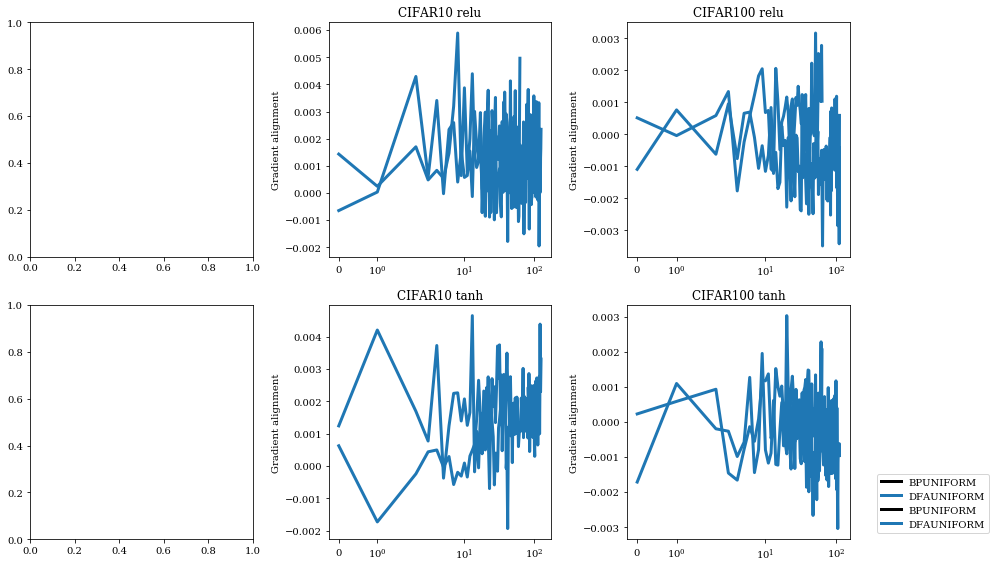

In [283]:
fig, axarr = plt.subplots(2,3,figsize=(12,8))

for j, dataset in enumerate(['MNIST','CIFAR10', 'CIFAR100']):
    for i, activation in enumerate(['relu', 'tanh']):
        for k, feedback_init in enumerate(params['feedback_init']):
            
            constraints = {'dataset' : dataset,
                          'activation' : activation,
                          'feedback_init': feedback_init}
            
            selected_runs, _ = select_runs(runs, params, constraints)

            for run in selected_runs:
                args = run['args']
                #if args.training_method=='BP' and feedback_init != 'UNIFORM': continue
                axarr[i,j].plot(np.array(run['grad_alignments'][0]), 
                              color='C%d'%k if args.training_method=='DFA' else 'k',
                              label=args.training_method+feedback_init)# if args.training_method=='DFA' else 'BP')
                axarr[i,j].set_ylabel('Gradient alignment')
                axarr[i,j].set_title('{} {}'.format(dataset, activation))
                axarr[i,j].set_xscale('symlog')
                fig.tight_layout()
axarr[-1,-1].legend(bbox_to_anchor=(1.1,0.3))
plt.show()

Time :  412
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): DFALayer()
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): ReLU()
    (5): DFALayer()
    (6): Reshape([4096])
    (7): Linear(in_features=4096, out_features=100, bias=False)
    (8): DFA(
      (dfa_layers): ModuleList(
        (0): DFALayer()
        (1): DFALayer()
      )
    )
  )
  (dfa_layers): ModuleList(
    (0): DFALayer()
    (1): DFALayer()
  )
  (dfa): DFA(
    (dfa_layers): ModuleList(
      (0): DFALayer()
      (1): DFALayer()
    )
  )
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)
tensor(0.5000) tensor(0.2461)


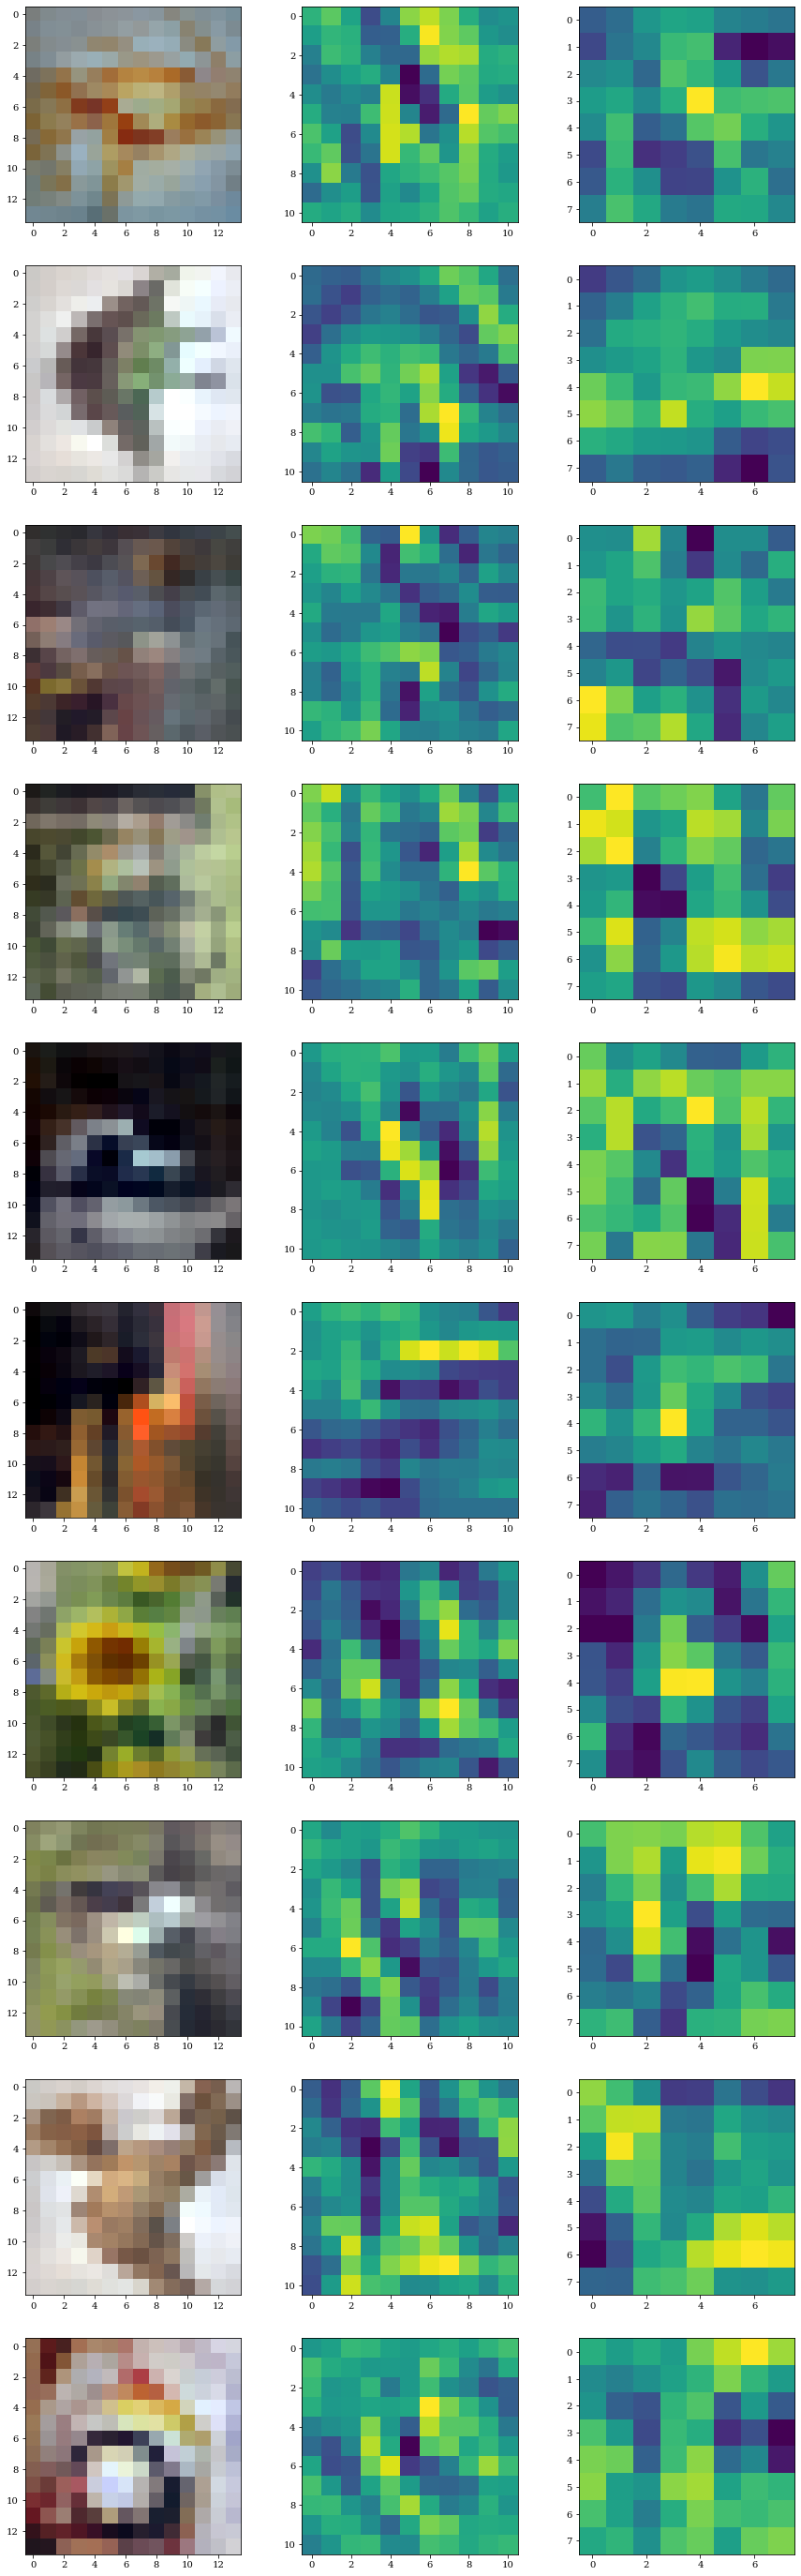

In [212]:
from models import ConvNet
itime = 29
n_images = 10

constraints = {'dataset' : 'CIFAR100',
               'activation' : 'relu',
               'feedback_init': 'UNIFORM',
               'training_method':'DFA'}
            
selected_runs, _ = select_runs(runs, params, constraints)
run = selected_runs[0]
times = list(run['weights'].keys())
time = times[itime]
print('Time : ', time)
state_dict = run['weights'][time]
args = run['args']
#train_loader, train_loader_log, test_loader, input_size, output_size, input_channels = get_data(args.dataset, args.dataset_path, args.batch_size, 
#                                                                                                args.test_batch_size, num_classes=args.num_classes, 
#                                                                                                input_dim=args.input_dim, datasize=40, 
#                                                                                                label_noise=args.label_noise)
#images = list(train_loader)[0][0]
model = ConvNet(input_size = [input_channels, input_size, input_size], output_size = output_size,
                        kernel_size = args.kernel_size, channels=args.hidden_size, n_layers=args.n_layers-1, n_fc_layers=1,
                        training_method=args.training_method, activation=args.activation, 
                        feedback_init=args.feedback_init, weight_init = args.weight_init)
del(model.fc_layers)
model.load_state_dict(state_dict)
model.eval()

global view_output
def hook_fn(module, input, output):
    global view_output
    view_output = output

#for layer in list(state_dict.values())[:-1]:
#    fig, axarr = plt.subplots(1,n_channels, figsize=(3*n_channels,3))
#    for channel in range(n_channels):
#        axarr[channel].matd(layer[channel])
print(model)

fig, axarr = plt.subplots(n_images,args.n_layers, figsize=(5*args.n_layers,5*n_images))
ilayer=1
for layer in model.layers:
    if layer.__class__ != torch.nn.Conv2d: continue
    hook = layer.register_forward_hook(hook_fn)
    for img in range(n_images):
        with torch.no_grad(): _ = model(images)
        axarr[img,ilayer].imshow(view_output[img,0,:,:])
    hook.remove()
    ilayer+=1
for img in range(n_images):
    print(images.mean(), images.std())
    images = (images-images.mean(0))/images.std(0)
    images = (images+2)/4
    axarr[img,0].imshow(images[img].transpose(0,2).squeeze())
    #axarr[img,0].imshow(images[img].squeeze())

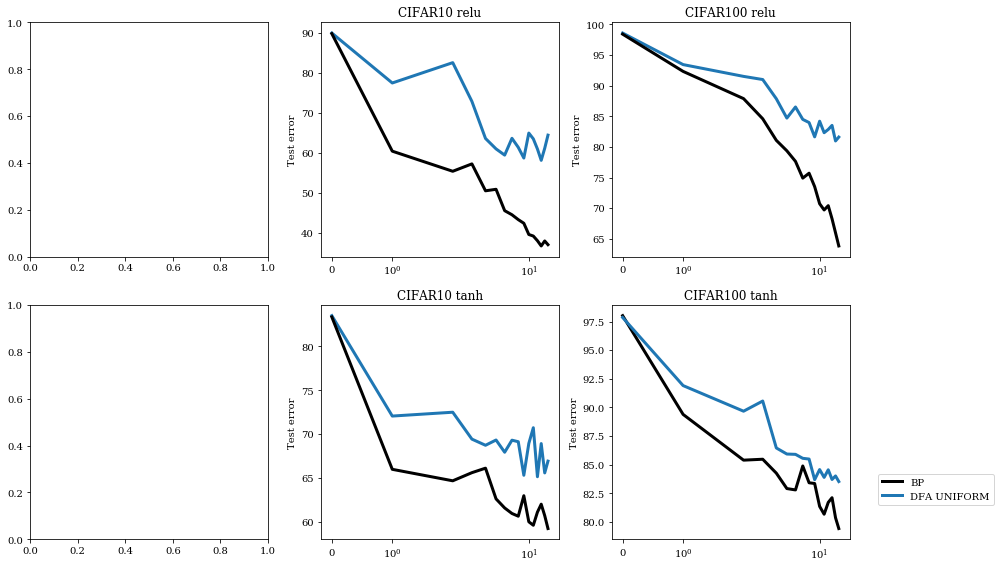

In [276]:
fig, axarr = plt.subplots(2,3,figsize=(12,8))

for j, dataset in enumerate(['MNIST','CIFAR10', 'CIFAR100']):
    for i, activation in enumerate(['relu', 'tanh']):
        for k, feedback_init in enumerate(params['feedback_init']):
            
            constraints = {'dataset' : dataset,
                          'activation' : activation,
                          'feedback_init': feedback_init}
            
            selected_runs, _ = select_runs(runs, params, constraints)

            for run in selected_runs:
                args = run['args']
                if args.training_method=='BP' and feedback_init != 'UNIFORM': continue
                axarr[i,j].plot(np.array(100-np.array(run['train_accs'])), 
                              color='C%d'%k if args.training_method=='DFA' else 'k',
                              label='DFA '+feedback_init if args.training_method=='DFA' else 'BP')
                axarr[i,j].set_ylabel('Test error')
                axarr[i,j].set_title('{} {}'.format(dataset, activation))
                axarr[i,j].set_xscale('symlog')
                fig.tight_layout()
axarr[-1,-1].legend(bbox_to_anchor=(1.1,0.3))
plt.show()

# Perturbation

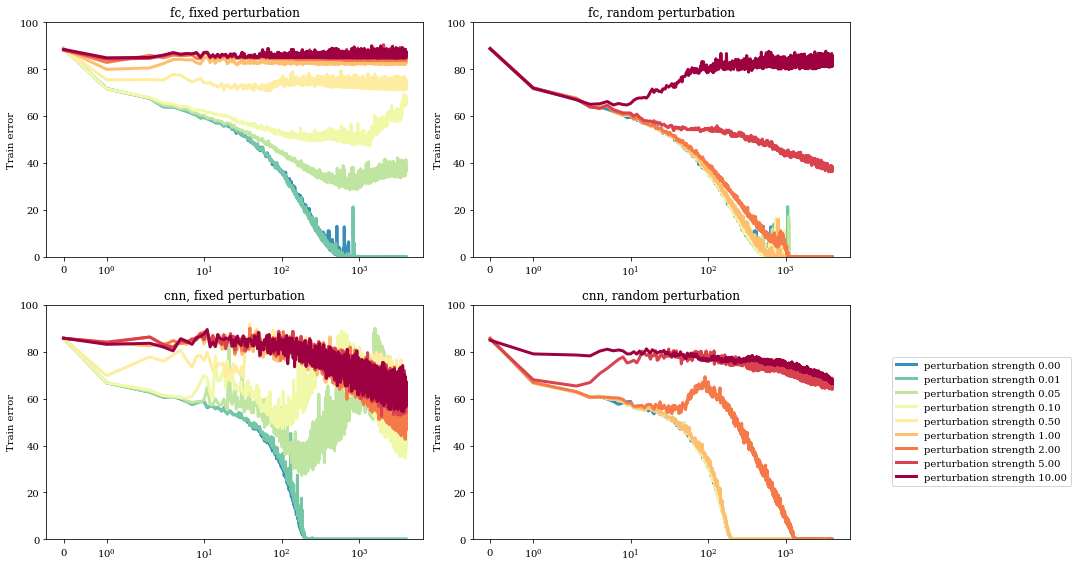

In [169]:
fig, axarr = plt.subplots(2,2,figsize=(12,8))

for i, model in enumerate(['fc','cnn']):
    for j, perturbation_type in enumerate(['FIXED','RANDOM']):
        for k, grad_perturbation in enumerate(params['grad_perturbation']):
            
            constraints = {'perturbation_type' : perturbation_type,
                           'activation' : 'tanh',
                           'grad_perturbation' : grad_perturbation,
                           'model' : model,
                          'training_method' : 'BP'}
            
            selected_runs, _ = select_runs(runs, params, constraints)

            for run in selected_runs:
                args = run['args']
                #training_method = args.training_method
                axarr[i,j].plot(np.array(100-np.array(run['train_accs'])), 
                              color=cmap((k+1)/len(params['grad_perturbation'])),
                              label='perturbation strength %.2f'%grad_perturbation)
                axarr[i,j].set_ylabel('Train error')
                axarr[i,j].set_title('{}, {} perturbation'.format(model, perturbation_type.lower()))
                axarr[i,j].set_xscale('symlog')
                axarr[i,j].set_ylim(0,100)
                fig.tight_layout()
#axarr[-1,-1].plot([],[],color='k',ls='-',label='DFA')
#axarr[-1,-1].plot([],[],color='k',ls='--',label='BP')
axarr[-1,-1].legend(bbox_to_anchor=(1.1,0.8))
plt.show()

# Matrix factorization

Error :  0.04743669311186232
(18, 100) (100, 144)
torch.Size([18, 18]) torch.Size([144, 18])


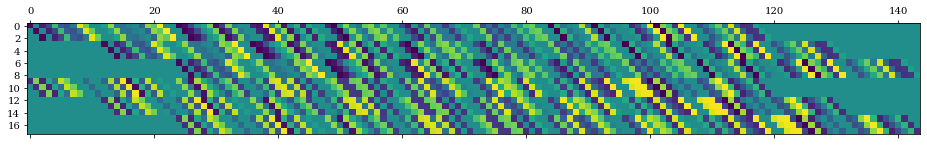

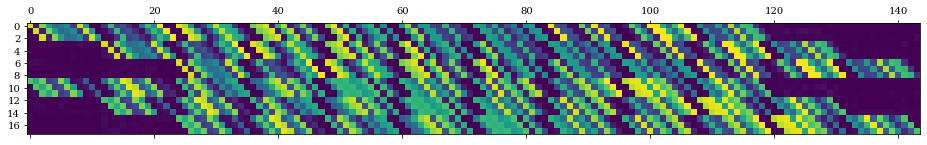

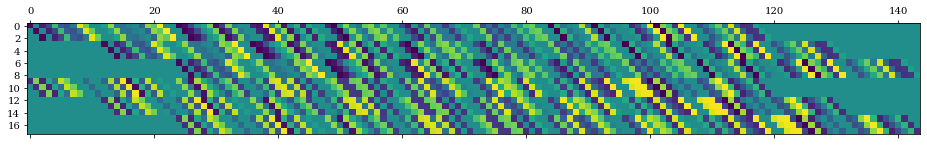

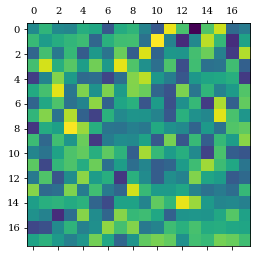

In [266]:
import importlib
import models
from models import ConvNet
from mappings import cnn2fc
from sklearn.decomposition import NMF

output_size = 100
model = ConvNet(input_size=[1,12,12], kernel_size=10, padding=0, stride=1,
                output_size=output_size, channels=2, n_layers=1, activation='relu', feedback_init='RANDOM', training_method='DFA')
model = cnn2fc(model, return_mask=False)
w = model.state_dict()['1.weight']
plt.matshow(w)

nmf = NMF(n_components=output_size, init='random', random_state=0, tol= 0.01)
W = nmf.fit_transform(w.abs())
print('Error : ', nmf.reconstruction_err_)
H = nmf.components_
print(np.shape(W), np.shape(H))
plt.matshow(W@H)

U,S,V = torch.svd(w)
U, S, V = U[:, :output_size], S[:output_size], V[:, :output_size]
U = U @ torch.diag(S**.5)
V = V @ torch.diag(S**.5)
print(U.size(), V.size())
plt.matshow(U @ V.t())
plt.show()
plt.matshow(U.t())

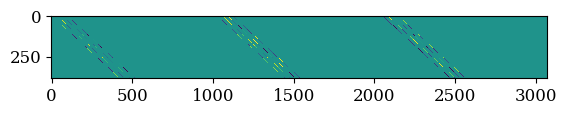

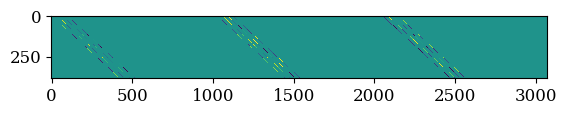

In [389]:
def eff_rank(m):
    evs = torch.symeig(m@m.t())[0]
    evs /= torch.sum(evs.abs())
    return torch.exp(-torch.sum(evs * torch.log(evs)))

for training_method in ['BP','DFA']:
    run = torch.load(training_method+'.pyT')
    args = run['args']
    weights = run['weights'][0]
    model = ConvNet(input_size = [3, 32, 32], output_size = 10,
                        kernel_size = args.kernel_size, channels=args.hidden_size, n_layers=args.n_layers,
                        training_method=args.training_method, activation=args.activation,
                        feedback_init=args.feedback_init, weight_init = args.weight_init)
    model.load_state_dict(weights)
    efcn = cnn2fc(model)
    w = efcn.state_dict()['1.weight']
    w = w[:w.size(1)//args.hidden_size]
    plt.imshow(w)
#    axarr[i].hist(spectrum, bins=40)
#    axarr[i].set_title('{}, effective rank {}'.format(training_method, int(rk)))
#    plt.suptitle('{}, {}'.format(dataset, activation))
#    plt.tight_layout(rect=[0,0,.95,.95])
    plt.show()